In [2]:
import pickle
import pandas as pd
from matplotlib import pyplot as plt
import sagemaker
import boto3 
import s3fs
import json
import datetime
from tzlocal import get_localzone as tzlocal
import numpy as np

In [3]:
import datetime
from tzlocal import get_localzone as tzlocal
import boto3
from tqdm import tqdm_notebook as tqdm

bucket_name = 'fog-bigdata-bmw-data'
s3_con = boto3.client('s3')
obj_list = s3_con.list_objects(Bucket=bucket_name,Prefix='metrics2/output')['Contents']
file_names = [key['Key'] for key in obj_list]

data = []
for file_name in tqdm(file_names):
    if not file_name.endswith('output.json'):
        continue
    file_str = s3_con.get_object(Bucket=bucket_name, Key=file_name).get('Body').read().decode('utf-8')
    batch = eval(file_str)
    
    for code in  ['response-code-200','response-code-4xx','response-code-5xx']:
        if code not in batch.keys():
            continue
        data = data + batch[code]['Datapoints']
        

In [4]:
from datetime import timedelta
df = pd.DataFrame(data)
# df.index = [i.replace(tzinfo=None) for i in pd.to_datetime(df.index)]
# df = df.drop(columns=['Unit'])
# df = df.groupby('Timestamp').sum()
# df['Timestamp'] = df.index
# df = df.drop_duplicates(keep='first')



In [5]:
df = pd.DataFrame(data)
df.index = [i.replace(tzinfo=None) for i in pd.to_datetime(df.Timestamp)]
df = df.drop(columns=['Unit'])
df = df.groupby('Timestamp').max()
series = pd.Series(data=df.SampleCount.values, index=[i.replace(tzinfo=None) for i in pd.to_datetime(df.index)])
series = series.sort_index()
#series = series[series.index < datetime.datetime(2019,1,26,0,0,0)]
data_freq = '5min'
series = series.groupby([pd.Grouper(freq=data_freq)]).sum()

# Apply a running mean to the last 15 minutes at each value
n_backsteps = 5
conv = np.hstack([np.ones(n_backsteps)/n_backsteps,np.zeros(n_backsteps-1)])
pad_vals = np.pad(series.values,n_backsteps-1,mode='edge')
series = pd.Series(data=np.convolve(pad_vals,conv,mode='valid'),index=series.index)

# Create feature series of holidays
end_of_holiday = datetime.date(2019, 1, 7)
holidays_data = [1 if time < pd.Timestamp(end_of_holiday,tz=None) else 0  for time in series.index]
holidays_feature_serie = pd.Series(data=holidays_data, index=series.index)

weekends_date = [0 if time.weekday() < 5 else 1 for time in series.index]
weekends_feature_series = pd.Series(data=weekends_date, index=series.index)




In [6]:
series[np.logical_and(series.index >= pd.Timestamp(2019,1,26),series.index < pd.Timestamp(2019,1,31,8,55))] /= 2

Text(0, 0.5, 'Number of samples')

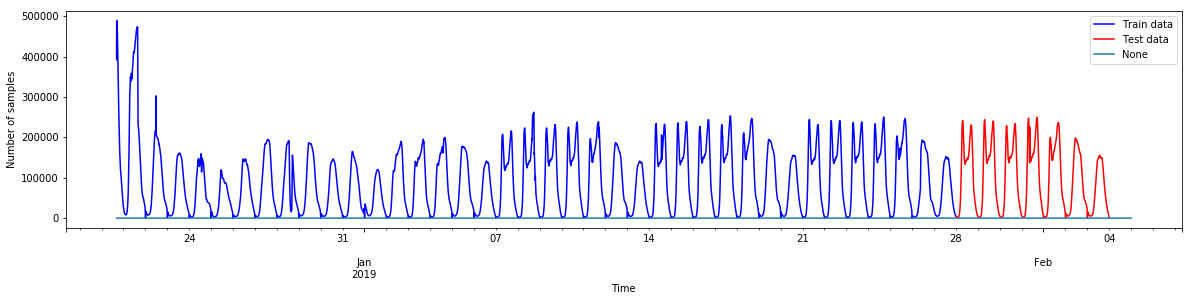

In [7]:
test_idx = np.logical_and(series.index > datetime.datetime(2019,1,28,0,0,0), series.index <= datetime.datetime(2019,2,4,0,0,0))
train_idx = series.index <= datetime.datetime(2019,1,28,0,0,0)

#demo_idx = [(idx > pd.Timestamp(end_of_holiday,tz=None) and idx < pd.Timestamp(datetime.date(2019, 1, 8),tz=None)) for idx in serie.index]
ax = series[train_idx].plot(
    figsize=(20,4),
    color='b',
    label='Train data'
)

series[test_idx].plot(
    color='r',
    label='Test data',
    ax = ax
)
weekends_feature_series.plot(ax=ax)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)

ax.set_xlabel('Time')
ax.set_ylabel('Number of samples')

2016

# Upload preprocessed data for random cut forest


In [9]:

from os import path 

data_bucket_name = 'fog-datasets'
prefix = 'rcf'

s3_data_path = "{}/{}/data".format(data_bucket_name, prefix)

s3filesystem = s3fs.S3FileSystem()

with s3filesystem.open(s3_data_path + "/train/data.csv", 'w') as fp:
    fp.write(series[train_idx].to_csv())

with s3filesystem.open(s3_data_path + "/test/data.csv", 'w') as fp:
    fp.write(series[test_idx].to_csv())


# Upload preprocessed data for DeepAR

In [22]:
import json
from deep_ar import series_to_jsonline
s3filesystem = s3fs.S3FileSystem()

# Upload preprocessed data for deep AR
data_bucket_name = 'fog-datasets'
prefix = 'deep_ar'
s3_data_path = "{}/{}/data".format(data_bucket_name, prefix)

with s3filesystem.open(s3_data_path + "/train/data.json", 'w') as fp:
    #fp.write(series_to_jsonline(series[train_idx], [list(holidays_feature_serie[train_idx]), list(weekends_feature_series[train_idx])]))
    fp.write(series_to_jsonline(series[train_idx], list(weekends_feature_series[train_idx])))

with s3filesystem.open(s3_data_path + "/test/data.json", 'w') as fp:
    #fp.write(series_to_jsonline(series[test_idx], [list(holidays_feature_serie[test_idx]), list(weekends_feature_series[test_idx])]))
    fp.write(series_to_jsonline(series[test_idx], list(weekends_feature_series[test_idx])))



In [23]:
import os
from sagemaker.amazon.amazon_estimator import get_image_uri
import boto3 


role = 'arn:aws:iam::746022503515:role/sage_maker'
image_name = get_image_uri(boto3.Session().region_name, 'forecasting-deepar')
data_bucket_name = 'fog-datasets'
prefix = 'deep_ar'
s3_output_path = "{}/{}/output".format(data_bucket_name, prefix)

train_locally = False

train_instance_type = 'ml.m5.2xlarge'

sagemaker_session = sagemaker.Session()

estimator = sagemaker.estimator.Estimator(
    sagemaker_session=sagemaker_session,
    image_name=image_name,
    role=role,
    train_instance_count=1,
    train_instance_type=train_instance_type,
    base_job_name='Weekly-Deepar',
    output_path="s3://" + s3_output_path
)

one_week_datapoints = 7*(60*24)//5

hyperparameters = dict(
    time_freq=data_freq,
    context_length=str(one_week_datapoints), # A quarter of an hour
    prediction_length=str(one_week_datapoints),
    num_cells="40",
    num_layers="3",
    likelihood="gaussian",
    epochs="20",
    mini_batch_size="32",
    learning_rate="0.001",
    dropout_rate="0.05",
    early_stopping_patience="10"
)

estimator.set_hyperparameters(**hyperparameters)

data_channels = {
    "train": "s3://{}/train/".format(s3_data_path),
    "test": "s3://{}/test/".format(s3_data_path)
}

estimator.fit(inputs=data_channels)

INFO:sagemaker:Creating training-job with name: Weekly-Deepar-2019-02-24-18-43-05-071


2019-02-24 18:43:05 Starting - Starting the training job...
2019-02-24 18:43:09 Starting - Launching requested ML instances......
2019-02-24 18:44:13 Starting - Preparing the instances for training...
2019-02-24 18:45:15 Downloading - Downloading input data
2019-02-24 18:45:15 Training - Downloading the training image..
Arguments: train
[02/24/2019 18:45:36 INFO 140310863755072] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'num_dynamic_feat': u'auto', u'dropout_rate': u'0.10', u'mini_batch_size': u'128', u'test_quantiles': u'[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'num_eval_samples': u'100', u'learning_rate': u'0.001', u'num_cells': u'40', u'num_layers': u'2', u'embedding_dimension': u'10', u'_kvstore': u'auto', u'_num_kv_servers': u'auto', u'cardinality': u'auto', u'likelihood': u'student-t', u'early_stopping_patience': u''}
[02/24/2019 18:45:36 INFO 14031086

[02/24/2019 19:10:44 INFO 140310863755072] Epoch[2] Batch[0] avg_epoch_loss=11.490738
[02/24/2019 19:11:08 INFO 140310863755072] Epoch[2] Batch[5] avg_epoch_loss=11.235143
[02/24/2019 19:11:08 INFO 140310863755072] Epoch[2] Batch [5]#011Speed: 6.67 samples/sec#011loss=11.235143
[02/24/2019 19:11:32 INFO 140310863755072] Epoch[2] Batch[10] avg_epoch_loss=11.158480
[02/24/2019 19:11:32 INFO 140310863755072] Epoch[2] Batch [10]#011Speed: 6.70 samples/sec#011loss=11.066485
[02/24/2019 19:11:32 INFO 140310863755072] processed a total of 336 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 53055.70101737976, "sum": 53055.70101737976, "min": 53055.70101737976}}, "EndTime": 1551035492.490063, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1551035439.434304}

[02/24/2019 19:11:32 INFO 140310863755072] #throughput_metric: host=algo-1, train throughput=6.33295594512 records/second
[02/24/2019 19:11:32 INFO 140310863755072] #prog

[02/24/2019 19:16:35 INFO 140310863755072] Epoch[8] Batch[5] avg_epoch_loss=9.540539
[02/24/2019 19:16:35 INFO 140310863755072] Epoch[8] Batch [5]#011Speed: 6.68 samples/sec#011loss=9.540539
[02/24/2019 19:16:54 INFO 140310863755072] processed a total of 298 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 48224.7850894928, "sum": 48224.7850894928, "min": 48224.7850894928}}, "EndTime": 1551035814.313393, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1551035766.088387}

[02/24/2019 19:16:54 INFO 140310863755072] #throughput_metric: host=algo-1, train throughput=6.17938317129 records/second
[02/24/2019 19:16:54 INFO 140310863755072] #progress_metric: host=algo-1, completed 45 % of epochs
[02/24/2019 19:16:54 INFO 140310863755072] best epoch loss so far
[02/24/2019 19:16:56 INFO 140310863755072] Saved checkpoint to "/opt/ml/model/state_882c6b5d-4ae5-4407-8dc1-261121fbb7bb-0000.params"
#metrics {"Metrics": {"state.serial

[02/24/2019 19:21:21 INFO 140310863755072] Epoch[14] Batch[0] avg_epoch_loss=8.989689
[02/24/2019 19:21:45 INFO 140310863755072] Epoch[14] Batch[5] avg_epoch_loss=9.060167
[02/24/2019 19:21:45 INFO 140310863755072] Epoch[14] Batch [5]#011Speed: 6.68 samples/sec#011loss=9.060167
[02/24/2019 19:22:09 INFO 140310863755072] Epoch[14] Batch[10] avg_epoch_loss=9.163493
[02/24/2019 19:22:09 INFO 140310863755072] Epoch[14] Batch [10]#011Speed: 6.70 samples/sec#011loss=9.287484
[02/24/2019 19:22:09 INFO 140310863755072] processed a total of 329 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 52992.98191070557, "sum": 52992.98191070557, "min": 52992.98191070557}}, "EndTime": 1551036129.678419, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1551036076.685384}

[02/24/2019 19:22:09 INFO 140310863755072] #throughput_metric: host=algo-1, train throughput=6.20835845248 records/second
[02/24/2019 19:22:09 INFO 140310863755072] #prog

KeyboardInterrupt: 

In [35]:
# Create endpoint
from deep_ar import DeepARPredictor
from sagemaker.amazon.amazon_estimator import get_image_uri

#job_name = estimator.latest_training_job.name
job_name = 'Weekly-Deepar-2019-02-23-20-41-14-700'

role = 'arn:aws:iam::746022503515:role/sage_maker'
image_name = get_image_uri(boto3.Session().region_name, 'forecasting-deepar')

endpoint_name = sagemaker_session.endpoint_from_job(
    job_name=job_name,
    initial_instance_count=1,
    instance_type='ml.m4.xlarge',
    deployment_image=image_name,
    role=role
)

INFO:sagemaker:Creating model with name: Weekly-Deepar-2019-02-23-20-41-14-700
INFO:sagemaker:Creating endpoint-config with name Weekly-Deepar-2019-02-23-20-41-14-700
INFO:sagemaker:Creating endpoint with name Weekly-Deepar-2019-02-23-20-41-14-700


ResourceLimitExceeded: An error occurred (ResourceLimitExceeded) when calling the CreateEndpoint operation: The account-level service limit 'Number of instances across active endpoints' is 3 Instances, with current utilization of 3 Instances and a request delta of 1 Instances. Please contact AWS support to request an increase for this limit.

In [7]:
from deep_ar import DeepARPredictor
sagemaker_session = sagemaker.Session()


predictor = DeepARPredictor(
    endpoint='DEMO-deepar-2019-02-07-14-12-24-232',
    sagemaker_session=sagemaker_session,
    content_type="application/json"
)



In [8]:
one_week_datapoints = 7*(60*24)//5

dyn = [
    list(weekends_feature_series[train_idx][-len(series[test_idx]):])+[0 if i.weekday() < 5 else 1 for i in series[test_idx].index]
]
predictor.set_prediction_parameters(freq=data_freq, prediction_length=len(series[test_idx]))
predictions = predictor.predict([series[train_idx][-len(series[test_idx]):]], 
                                dyn
                                )



<Figure size 864x432 with 0 Axes>

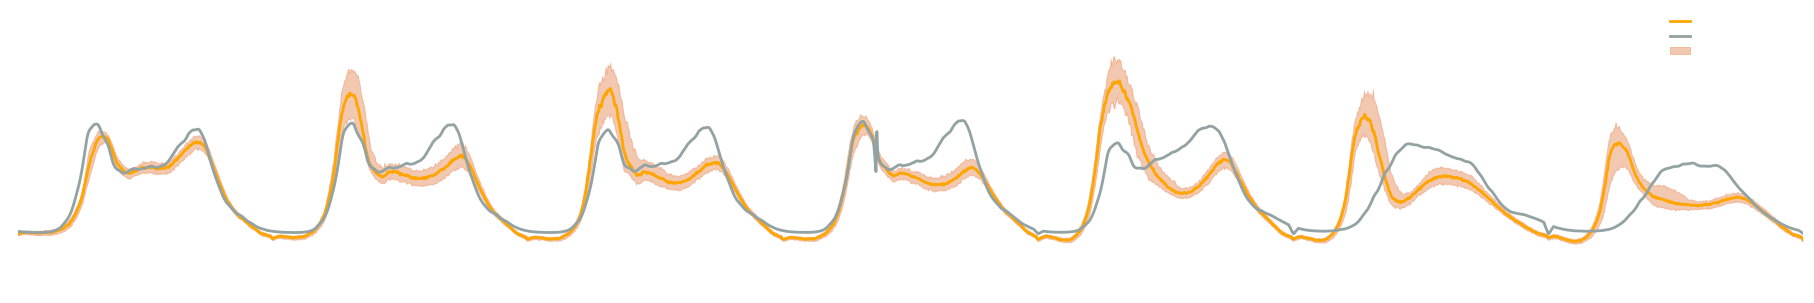

In [26]:
#predictions[0].to_csv('deepar_weekly_trained_weekends.csv')
predictions = [pd.read_csv('deepar_no_dyn.csv')]
for k in range(len(predictions)):
    plt.figure(figsize=(12,6))
    # series[test_idx].plot(label='target')
    p10 = predictions[k]['0.1']
    p90 = predictions[k]['0.9']
    #plt.fill_between(p10.index, p10, p90, color='y', alpha=0.5, label='80% confidence interval')
    #predictions[k]['0.5'].plot(label='prediction median')
    #plt.legend()
    #plt.show()

    
    fig, ax = plt.subplots(1,figsize=(32,5))

    c = 'white'
    ax.plot(np.arange(len(predictions[k])),predictions[k]["0.5"].values,linewidth=2.8,color='orange',label='Expected Value')
    ax.plot(np.arange(len(series[test_idx])),series[test_idx].values, label='Ground truth',color="#93A2A2",linewidth=2.8)
    ax.fill_between(
        np.arange(len(predictions[k])),
        p10, 
        p90,
        color='#E99365',
        alpha=0.5,
        label='Standard Deviation'
    )
    ax.set_ylim(-100000,500000)
    ax.set_yticks(np.linspace(0,500000,4))
    ax.set_yticklabels(np.linspace(0,3,4,dtype='int'))
    #     ax.set_ylabel('100k requests per 5min',fontdict=dict(color=c,size=10))
    ax.axes.yaxis.set_visible(False)
    ax.set_xticks(np.linspace(0,len(predictions[k]),8))
    ax.set_xticklabels(['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
    ax.set_xlim(0,len(predictions[k]))
    ax.spines['bottom'].set_color('grey')
    ax.spines['bottom'].set_alpha(0)
    ax.spines['top'].set_color('grey') 
    ax.spines['top'].set_alpha(0)
    ax.spines['right'].set_color('grey')
    ax.spines['right'].set_alpha(0)
    ax.spines['left'].set_color('grey')
    ax.spines['left'].set_alpha(0)
    ax.tick_params(axis='x', colors=c)
    ax.tick_params(axis='y', colors=c)
    ax.title.set_color(c)
    ax.legend(prop={'size': 20})

    l = ax.legend(framealpha=0)
    for text in l.get_texts():
        text.set_color(c)
    fig.savefig('plots/deepar_no_dyn.png',transparent=True)

# Select two weeks of working days to mock data streaming

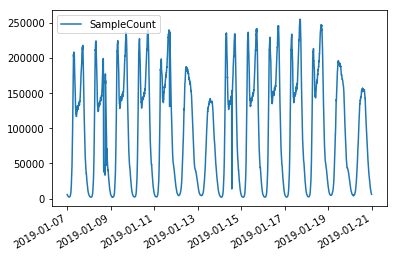

In [26]:
df.index = [i.replace(tzinfo=None) for i in df.index]
s_df = df[df.index>=pd.to_datetime('2019-01-07')]
s_df = s_df[s_df.index<pd.to_datetime('2019-01-21')]
s_df.plot()

with s3filesystem.open('s3://fog-datasets/streaming-data-mock.csv', 'w') as fp:
    fp.write(df.to_csv())


In [43]:
predictor.set_prediction_parameters(data_freq, n_weekly_datapoints)

synthetic_series = series[series.index>=pd.to_datetime('2019-01-07')]
synthetic_series = synthetic_series[synthetic_series.index<pd.to_datetime('2019-01-21')]
#'response-code-200': {'Label': 'response-code-200', 'Datapoints': [{'Timestamp': datetime.datetime(2019, 1, 5, 19, 30, tzinfo=tzlocal()), 'SampleCount': 67152.0, 'Unit': 'None'},


datapoints = []
for time, value in synthetic_series.iteritems():
    datapoints.append({'Timestamp':datetime.datetime(time.year,time.month,time.day, time.hour, time.minute, tzinfo=tzlocal()), 'SampleCount': value, 'Unit': 'None'})


# Upload preprocessed data for deep AR
data_bucket_name = 'fog-datasets'
prefix = 'streaming-data-mock'
s3_data_path = "{}/{}".format(data_bucket_name, prefix)
s3filesystem = s3fs.S3FileSystem()

out = {
    'response-code-200': {'Label': 'response-code-200', 'Datapoints':datapoints}
}

with s3filesystem.open(s3_data_path + ".json", 'w') as fp:
    fp.write(repr(out))
    

file_str = s3_con.get_object(Bucket=data_bucket_name, Key=prefix+".json").get('Body').read().decode('utf-8')
batch = eval(file_str)



EndpointConnectionError: Could not connect to the endpoint URL: "https://fog-datasets.s3.amazonaws.com/streaming-data-mock.json"